## Semantic Segmentation using MobileNetV2

Setting up the link with google drive to load images and save the results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set google drive for files
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Colab Notebooks/temp/b08d5871a151.json"
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/drive/My Drive/Colab Notebooks/temp/b08d5871a151.json


Loading the required libraries

In [ ]:
import os
import glob
import tarfile
import tempfile
from io import BytesIO
from six.moves import urllib

import numpy as np
from PIL import Image
from matplotlib import gridspec
from matplotlib import pyplot as plt

%tensorflow_version 1.x
import tensorflow as tf

The code for this task is adapted from https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

Defining helper methods

In [ ]:
class DeepLabModel():
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        """Runs inference on a single image.

        Args:
          image: A PIL.Image object, raw input image.

        Returns:
          resized_image: RGB image resized from original input image.
          seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

In [ ]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
    A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
    label: A 2D array with integer type, storing the segmentation label.

    Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

    Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map, image_path):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    image_path = image_path.replace('/image_data/data/', '/image_data/results/')
    # Image.fromarray(seg_image).save(image_path)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    ax2 = plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.savefig(image_path)
    #plt.show()
    

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

Downloading MobileNetv2 as pretrained model

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug' 
_MODEL_URL = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_MODEL_URL, download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

Running the model on sample data and saving the results

In [ ]:
def run_visualization(image_path):
    """Inferences DeepLab model and visualizes result."""
    try:
        original_im = Image.open(image_path)
    except IOError:
        print('Cannot retrieve image. Please check file path: ' + image_path)
        return

    print('running deeplab on image %s...' % image_path)
    resized_im, seg_map = MODEL.run(original_im)

vis_segmentation(resized_im, seg_map, image_path)

path = "/content/drive/My Drive/image_data/data"
filepaths = glob.glob(path + "/*.*")

for fp in filepaths:
    print(fp)
    run_visualization(fp)


def run_visualization(image_path):
    """Inferences DeepLab model and visualizes result."""
    try:
        original_im = Image.open(image_path)
    except IOError:
        print('Cannot retrieve image. Please check file path: ' + image_path)
        return

    print('running deeplab on image %s...' % image_path)
    resized_im, seg_map = MODEL.run(original_im)

vis_segmentation(resized_im, seg_map, image_path)

path = "/content/drive/My Drive/image_data/data"
filepaths = glob.glob(path + "/*.*")

for fp in filepaths:
    print(fp)
    run_visualization(fp)


Defining helper methods

In [ ]:
class DeepLabModel():
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        """Runs inference on a single image.

        Args:
          image: A PIL.Image object, raw input image.

        Returns:
          resized_image: RGB image resized from original input image.
          seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

In [ ]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
    A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
    label: A 2D array with integer type, storing the segmentation label.

    Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

    Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map, image_path):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    image_path = image_path.replace('/image_data/data/', '/image_data/results/')
    # Image.fromarray(seg_image).save(image_path)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    ax2 = plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.savefig(image_path)
    #plt.show()
    

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

Downloading MobileNetv2 as pretrained model

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug' 
_MODEL_URL = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_MODEL_URL, download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


Running the model on sample data and saving the results

/content/drive/My Drive/image_data/data/H19FC.jpg
running deeplab on image /content/drive/My Drive/image_data/data/H19FC.jpg...


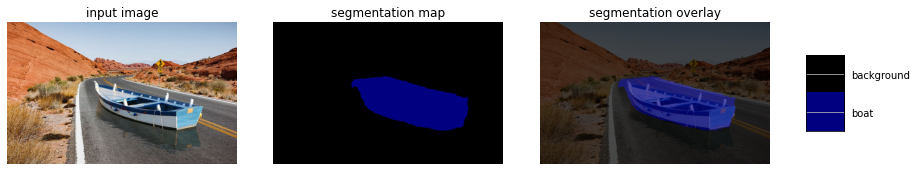

/content/drive/My Drive/image_data/data/FJEUM.jpg
running deeplab on image /content/drive/My Drive/image_data/data/FJEUM.jpg...


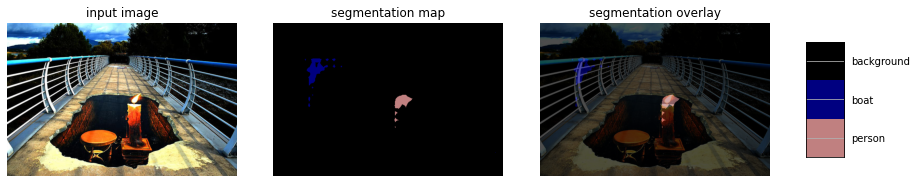

/content/drive/My Drive/image_data/data/9NS1Q.jpg
running deeplab on image /content/drive/My Drive/image_data/data/9NS1Q.jpg...


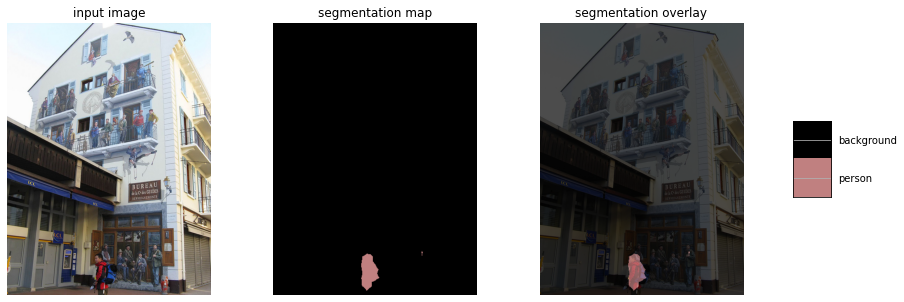

/content/drive/My Drive/image_data/data/PXWW5.jpg
running deeplab on image /content/drive/My Drive/image_data/data/PXWW5.jpg...


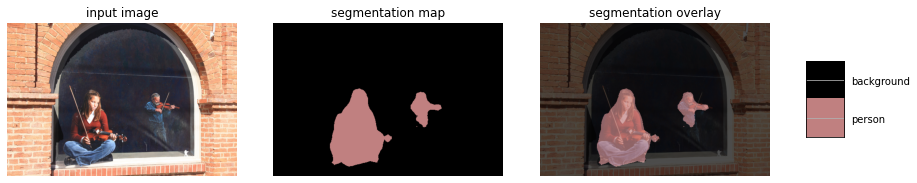

/content/drive/My Drive/image_data/data/ISNWU.jpg
running deeplab on image /content/drive/My Drive/image_data/data/ISNWU.jpg...


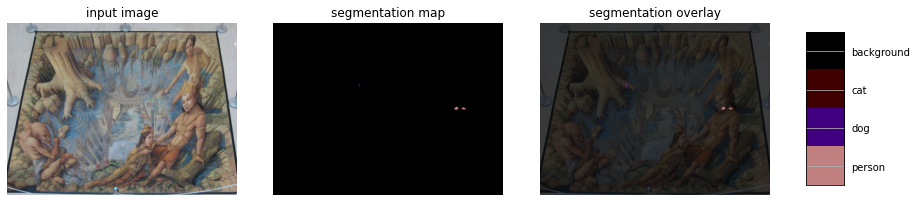

/content/drive/My Drive/image_data/data/ENQVW.jpg
running deeplab on image /content/drive/My Drive/image_data/data/ENQVW.jpg...


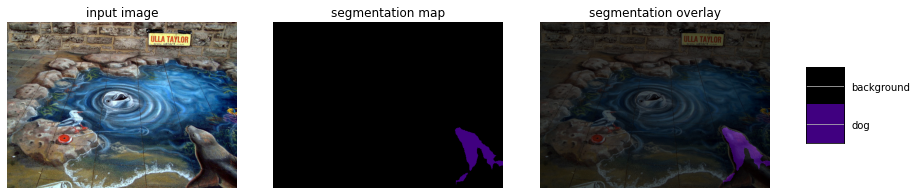

/content/drive/My Drive/image_data/data/OAJP0.jpeg
running deeplab on image /content/drive/My Drive/image_data/data/OAJP0.jpeg...


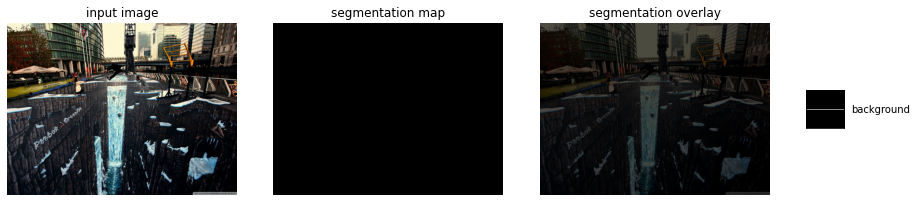

/content/drive/My Drive/image_data/data/9GMSO.jpg
running deeplab on image /content/drive/My Drive/image_data/data/9GMSO.jpg...


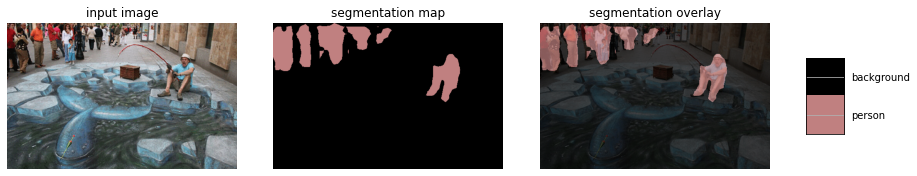

/content/drive/My Drive/image_data/data/A4J81.jpg
running deeplab on image /content/drive/My Drive/image_data/data/A4J81.jpg...


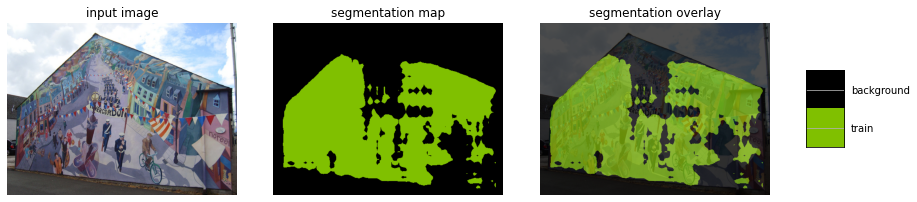

/content/drive/My Drive/image_data/data/WHW0S.jpg
running deeplab on image /content/drive/My Drive/image_data/data/WHW0S.jpg...


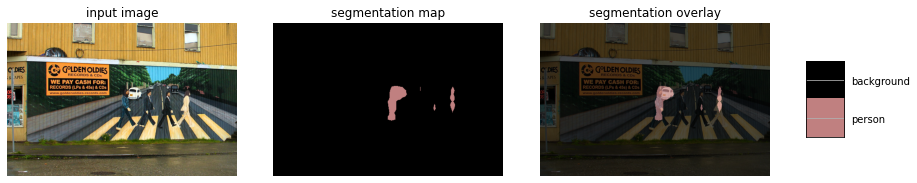

/content/drive/My Drive/image_data/data/S9DV9.jpg
running deeplab on image /content/drive/My Drive/image_data/data/S9DV9.jpg...


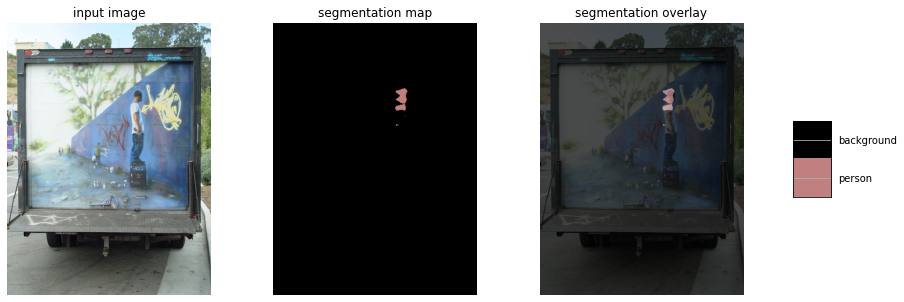

/content/drive/My Drive/image_data/data/VB4MK.jpg
running deeplab on image /content/drive/My Drive/image_data/data/VB4MK.jpg...


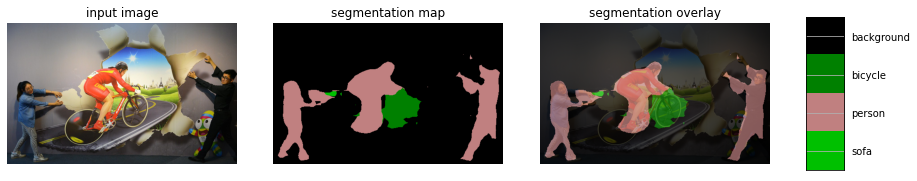

/content/drive/My Drive/image_data/data/A8HUE.jpg
running deeplab on image /content/drive/My Drive/image_data/data/A8HUE.jpg...


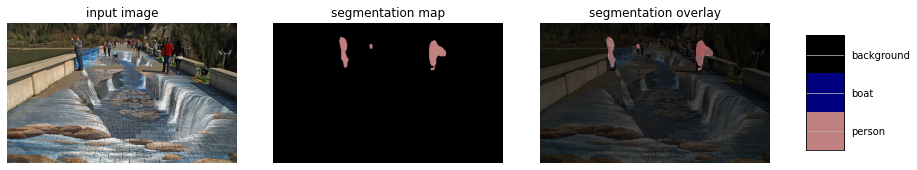

/content/drive/My Drive/image_data/data/RUNFG.jpg
running deeplab on image /content/drive/My Drive/image_data/data/RUNFG.jpg...


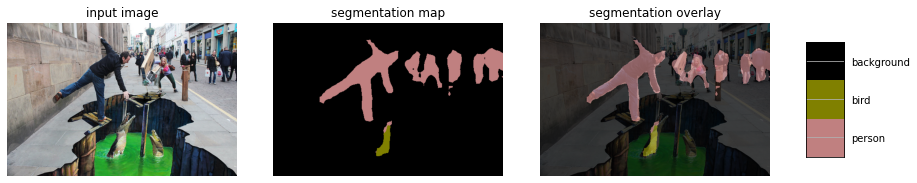

/content/drive/My Drive/image_data/data/B6JYW.jpg
running deeplab on image /content/drive/My Drive/image_data/data/B6JYW.jpg...


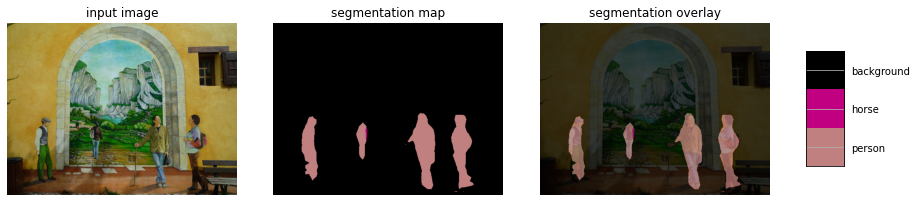

/content/drive/My Drive/image_data/data/6Y39V.jpg
running deeplab on image /content/drive/My Drive/image_data/data/6Y39V.jpg...


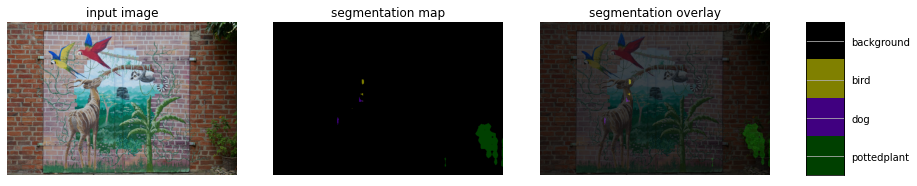

/content/drive/My Drive/image_data/data/BUA50.jpg
running deeplab on image /content/drive/My Drive/image_data/data/BUA50.jpg...


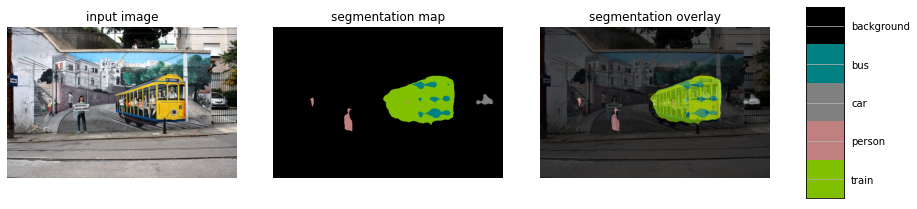

/content/drive/My Drive/image_data/data/C7I4B.jpg
running deeplab on image /content/drive/My Drive/image_data/data/C7I4B.jpg...


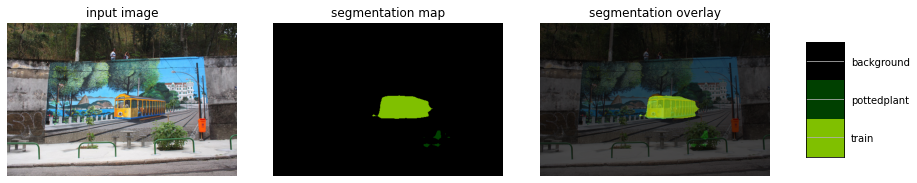

/content/drive/My Drive/image_data/data/3W7BB.jpg
running deeplab on image /content/drive/My Drive/image_data/data/3W7BB.jpg...


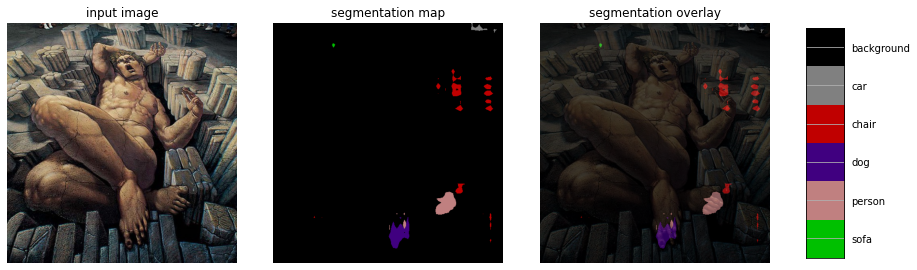

In [ ]:
def run_visualization(image_path):
    """Inferences DeepLab model and visualizes result."""
    try:
        original_im = Image.open(image_path)
    except IOError:
        print('Cannot retrieve image. Please check file path: ' + image_path)
        return

    print('running deeplab on image %s...' % image_path)
    resized_im, seg_map = MODEL.run(original_im)

vis_segmentation(resized_im, seg_map, image_path)

path = "/content/drive/My Drive/image_data/data"
filepaths = glob.glob(path + "/*.*")

for fp in filepaths:
    print(fp)
    run_visualization(fp)
